In [ ]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Discovery

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from keras import regularizers
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input
global DATA_PATH
global PUBLIC_TEST_PATH
global LABEL_PATH

In [ ]:
# Check if GPUs are available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Set TensorFlow to use all available GPUs
        tf.config.experimental.set_visible_devices(gpus, 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [ ]:
DATA_PATH = '/kaggle/input/ai-hackathon-2024-faces/data/mnt/md0/projects/sami-hackathon/private/data/'
PUBLIC_TEST_PATH = '/kaggle/input/ai-hackathon-2024-faces/public_test/public_test/'
LABEL_PATH = '/kaggle/input/ai-hackathon-2024-faces/labels.csv'

In [ ]:
label_df = pd.read_csv(LABEL_PATH)
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15310 entries, 0 to 15309
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  15310 non-null  object
 1   height     15310 non-null  int64 
 2   width      15310 non-null  int64 
 3   bbox       15310 non-null  object
 4   age        15310 non-null  object
 5   race       15310 non-null  object
 6   masked     15310 non-null  object
 7   skintone   15310 non-null  object
 8   emotion    15310 non-null  object
 9   gender     15310 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.2+ MB


In [ ]:
a = '[934.0000000000097, 144.82228672769534, 238.24562254582438, 330.0662796338281]'

def str_to_list(string: str):
    return list(map(round, map(float, string[1:-1].split(", "))))

str_to_list(a)

[934, 145, 238, 330]

In [ ]:
label_df["bbox"] = label_df["bbox"].apply(str_to_list)

In [ ]:
bbox = label_df[["file_name", "bbox", "masked"]]

In [ ]:
# file_name, (x, y, w, h), masked = masked_label.iloc[0]
# img = cv2.imread(DATA_PATH+file_name)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# face = img[y:y+h, x:x+w]
# face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
# face = cv2.resize(face, (224, 224))

# # img_with_box = cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
# # img_with_box = cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB)
# # cv2.putText(img_with_box, masked, (x,y-10), cv2.COLOR_BGR2RGB, 0.9, (0,255,0), 2)
# plt.title(masked)
# plt.imshow(img)
# plt.show()

In [ ]:
def check_img(file:str, bbox: set, masked: str):
    x,y,w,h=bbox
    img = cv2.imread(DATA_PATH+file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_with_box = cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
    img_with_box = cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB)
    cv2.putText(img_with_box, masked, (x,y-10), cv2.COLOR_BGR2RGB, 0.9, (0,255,0), 2)
    plt.title(masked)
    plt.imshow(img)
    plt.show()

In [ ]:
label_df = pd.read_csv(LABEL_PATH)
label_df["bbox"] = label_df["bbox"].apply(str_to_list)
bbox_masked_dict = {}

length = label_df.shape[0]
for i in range(length):
    file = label_df.at[i, "file_name"]
    bb = label_df.at[i, "bbox"]
    masked = label_df.at[i, "masked"]
    if file not in bbox_masked_dict:
        bbox_masked_dict[file] = ([], [])
    bbox_masked_dict[file][0].append(bb)
    bbox_masked_dict[file][1].append(masked)
len(bbox_masked_dict)

15000

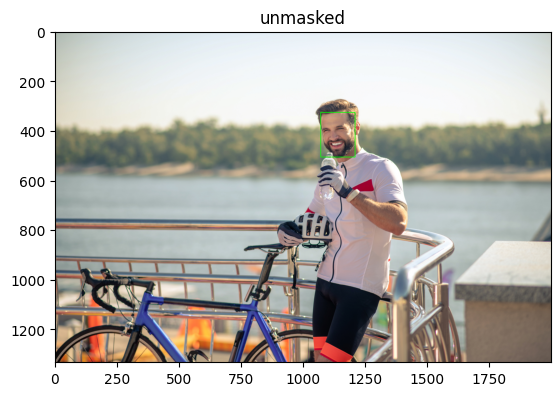

In [ ]:
import random
n = random.randint(0,length)
list_name = list(bbox_masked_dict.keys())
check_img(
    list_name[n],
    bbox_masked_dict[list_name[n]][0][0],
    bbox_masked_dict[list_name[n]][1][0]
)

# Load Data

In [ ]:
! pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.8 MB/s eta 0:00:00:00:010:01


In [ ]:
from mtcnn import MTCNN

class FaceLoading:
    def __init__(self, directory, is_train=True):
        self.directory = directory
        self.target_size = (224, 224)
        self.X = []
        self.y = []
        self.is_train = is_train
        self.detector = MTCNN() if not is_train else None


    def extract_data(self, filename, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        data = []
        for bb, lb in zip(bbox_masked_dict[filename][0], bbox_masked_dict[filename][1]):
            face = img[bb[1]:bb[1]+bb[3], bb[0]:bb[0]+bb[2]]
            face = cv2.resize(face, self.target_size)
            data.append((face, lb))
        return data

    def load_data(self):
        for im_name in os.listdir(self.directory):
            try:
                path = self.directory + '/' + im_name
                data = self.extract_data(im_name, path)
                self.X.extend([dt[0] for dt in data])
                self.y.extend([dt[1] for dt in data])
            except Exception as e:
                pass
        return np.asarray(self.X), np.asarray(self.y)


    '''
    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')
    '''

In [ ]:
faceloading = FaceLoading(DATA_PATH)
X, y = faceloading.load_data()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_shape = (224,224,3)
classes = list(label_df["masked"].unique())
EPOCHS = 50
BS = 32

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
y

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
X = tf.keras.applications.mobilenet_v2.preprocess_input(X)

In [ ]:
# X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((12248, 224, 224, 3), (12248,))

In [ ]:
X_test.shape, y_test.shape

((3062, 224, 224, 3), (3062,))

In [ ]:
import gc

In [ ]:
del X
gc.collect()

3592

In [ ]:
del y
gc.collect()

0

In [ ]:
# Import necessary libraries
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=len(classes))

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
class_weight_dict

{0: 15.046683046683047, 1: 0.5171860484756355}

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_datagen = datagen.flow(X_train, y_train, batch_size=BS, shuffle=True)

In [ ]:
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation = 'tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation = 'tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(64, activation = 'tanh'),
    Dropout(0.5),
    Dense(32, activation = 'tanh'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(
    train_datagen,
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=5,
    class_weight=class_weight_dict,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
382/382 [==============================] - 140s 346ms/step - loss: 5.9089 - accuracy: 0.8719 - val_loss: 5.1648 - val_accuracy: 0.9847 - lr: 1.0000e-04
Epoch 2/5
382/382 [==============================] - 123s 323ms/step - loss: 4.9011 - accuracy: 0.9640 - lr: 1.0000e-04
Epoch 3/5
382/382 [==============================] - 122s 319ms/step - loss: 4.1599 - accuracy: 0.9759 - lr: 1.0000e-04
Epoch 4/5
382/382 [==============================] - 123s 321ms/step - loss: 3.5228 - accuracy: 0.9799 - lr: 1.0000e-04
Epoch 5/5
382/382 [==============================] - 127s 331ms/step - loss: 2.9763 - accuracy: 0.9767 - lr: 1.0000e-04


In [ ]:
history.history

{'loss': [5.9088945388793945,
  4.901128768920898,
  4.159890174865723,
  3.5228111743927,
  2.976252555847168],
 'accuracy': [0.8718893527984619,
  0.9639816880226135,
  0.9759331941604614,
  0.9799443483352661,
  0.97666996717453],
 'val_loss': [5.164829730987549],
 'val_accuracy': [0.9846505522727966],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

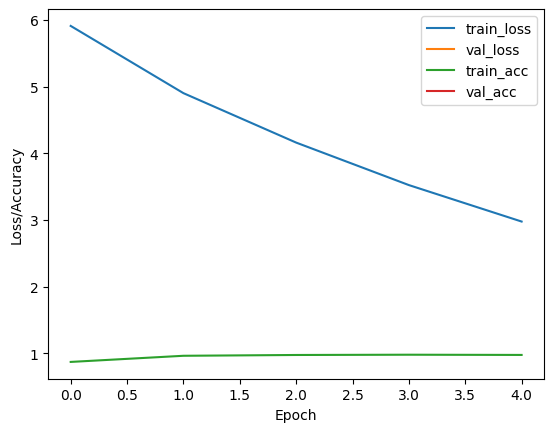

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

96/96 [==============================] - 5s 48ms/step
Confusion Matrix:
[[  97    0]
 [2965    0]]
Classification Report:
              precision    recall  f1-score   support

    unmasked       0.03      1.00      0.06        97
      masked       0.00      0.00      0.00      2965

    accuracy                           0.03      3062
   macro avg       0.02      0.50      0.03      3062
weighted avg       0.00      0.03      0.00      3062



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('/kaggle/working/my_model.keras')